# Air bnb Exploratory Data Analysis

In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



Reading dataset into a pandas dataframe

In [126]:
df = pd.read_csv('Data\AB_NYC_2019.csv')

In [127]:
df.shape

(48895, 16)

In [128]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


# Step 1: Analysis/Preprocessing

# Missing values

In [129]:
features_with_na = [feature  for feature in df.columns if df[feature].isnull().sum() >= 1]

for feature in features_with_na:
    print(feature, ':', np.round(df[feature].isnull().mean(), 4), "% missing values")

name : 0.0003 % missing values
host_name : 0.0004 % missing values
last_review : 0.2056 % missing values
reviews_per_month : 0.2056 % missing values


Now I will check if the nightly price has strong dependencies on the missing values

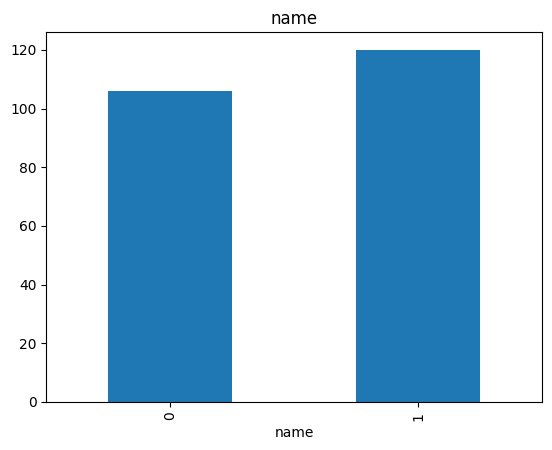

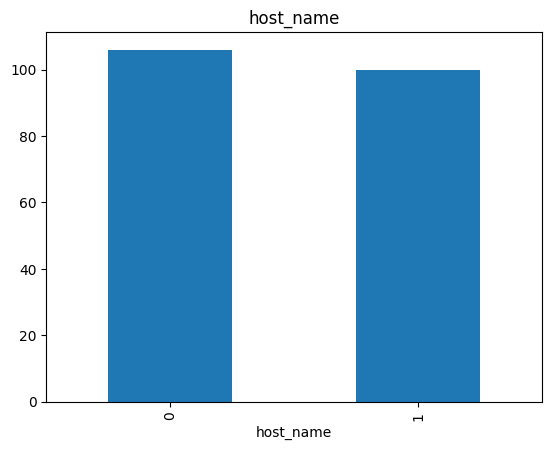

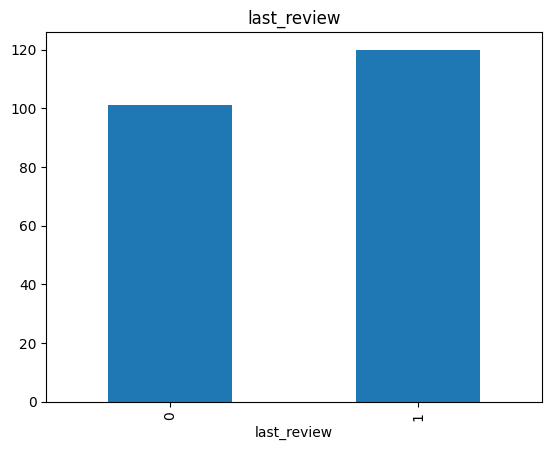

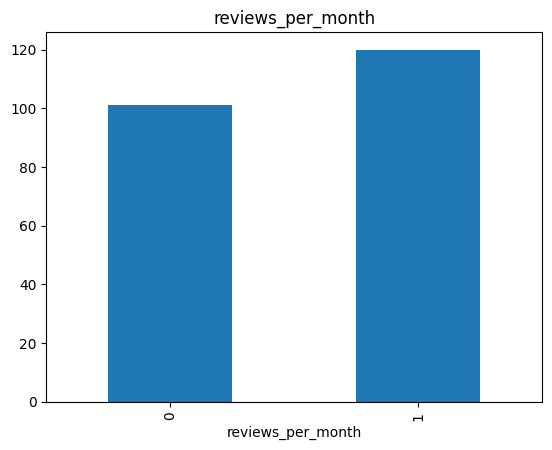

In [130]:
for feature in features_with_na:
    data = df.copy()

    data[feature] = np.where(data[feature].isnull(), 1, 0)

    data.groupby(feature)['price'].median().plot.bar()

    plt.title(feature)
    plt.show()

The name and host name missing values are so minute (around 0.0002) % so I will not be focusing too much on those missing values, and will be dropping the entries with missing values

However the missing values of the reviews are more significant (around 0.2056) and also show that that the price of the air bnb has some dependcies on it -  you can see in the bar chart that the median price of the entires that have missing values (1) is around 120, while the median price of the entries that do not include missing values (0) is around 100

This could be for a few reasons, if it is a newer building then it might be a higher price than an older one, and might not have been available for long enough for people to give them reviews

Also if they are more luxury or expensive, then it could be rented infrequently and therefore lack review data

This is all to show that I will not be ignoring the missing values in these features, but I will make sure to model them instead 

# Numerical Features

In [131]:
numerical_featurs = [feature for feature in df.columns if df[feature].dtypes != 'O']

print(f'Number of numerical features = {len(numerical_featurs)}')

df.head()

Number of numerical features = 10


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [132]:
print(numerical_featurs)


['id', 'host_id', 'latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']


# Temporal features

In [133]:
temporal_features = [feature for feature in df.columns if df[feature].dtype == 'datetime64[ns]']

print(temporal_features)

[]


In [134]:
string_features = [feature for feature in df.columns if df[feature].dtype == 'object']

print(string_features)

['name', 'host_name', 'neighbourhood_group', 'neighbourhood', 'room_type', 'last_review']


You can see that the dataframe is not treating the last review as a date_time object, so I will have to change that

In [135]:
df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')

In [136]:
temporal_features = [feature for feature in df.columns if df[feature].dtype == 'datetime64[ns]']

print(temporal_features)

['last_review']


Now I will plot the last review with the price to see if there are any patterns that stand out

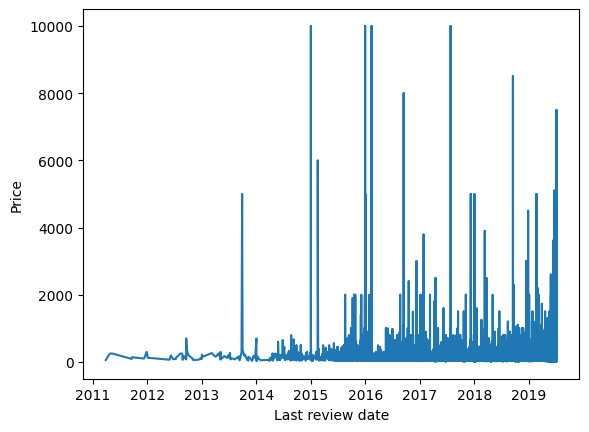

In [137]:
df_sorted = df.sort_values('last_review')

plt.plot(df_sorted['last_review'], df_sorted['price'])

plt.xlabel('Last review date')
plt.ylabel('Price')

plt.show()

too noisy so I will resample

C:\Users\logan\AppData\Local\Temp\ipykernel_21392\1980788542.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.set_index('last_review')['price'].resample('M').median().plot()


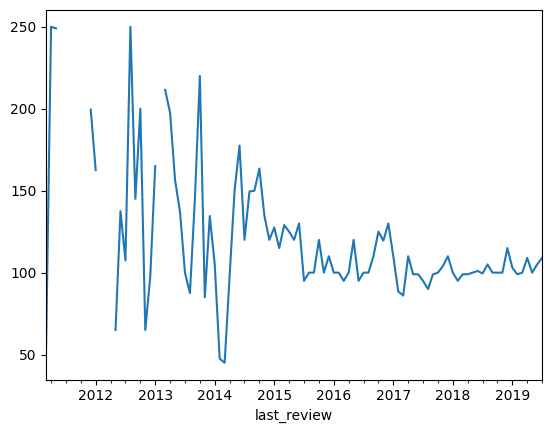

In [138]:
df.set_index('last_review')['price'].resample('M').median().plot()

plt.show()

no clear relationship, other than around 2015 the market gets a bit more stable, 

# Discrete and continuous features

In [139]:
discrete_features = [feature for feature in numerical_featurs if len(df[feature].unique()) <= 25 and feature not in ['id']+['host_id']]

discrete_features

[]

no discrete features in dataset, all numerical features are continuous 

In [140]:
continuous_features = [feature for feature in numerical_featurs if feature not in ['id'] + ['host_id']]

continuous_features

['latitude',
 'longitude',
 'price',
 'minimum_nights',
 'number_of_reviews',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365']

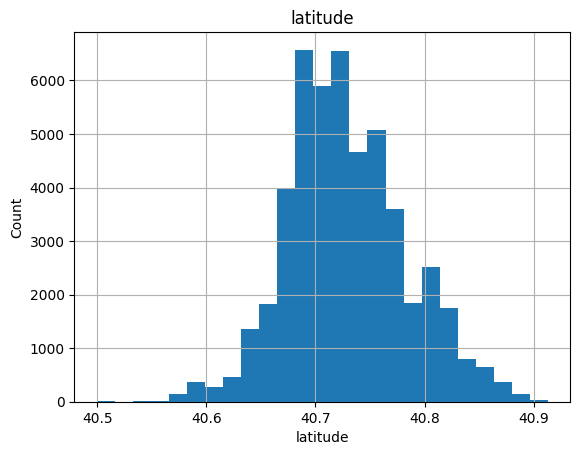

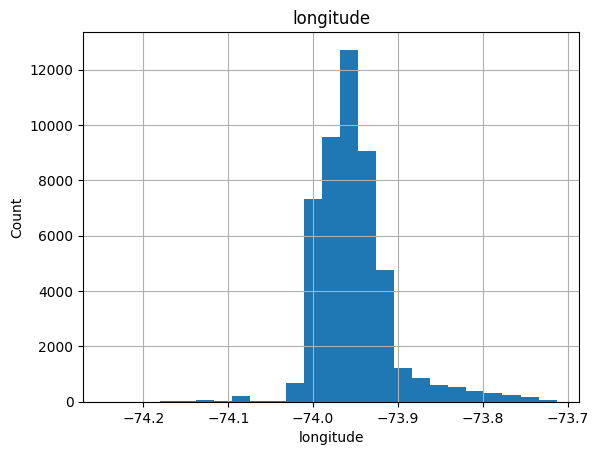

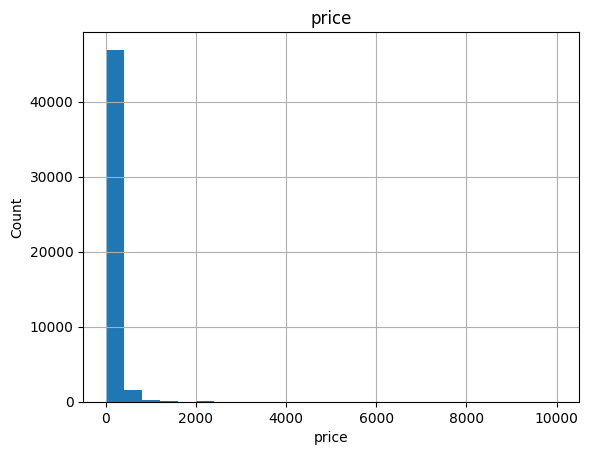

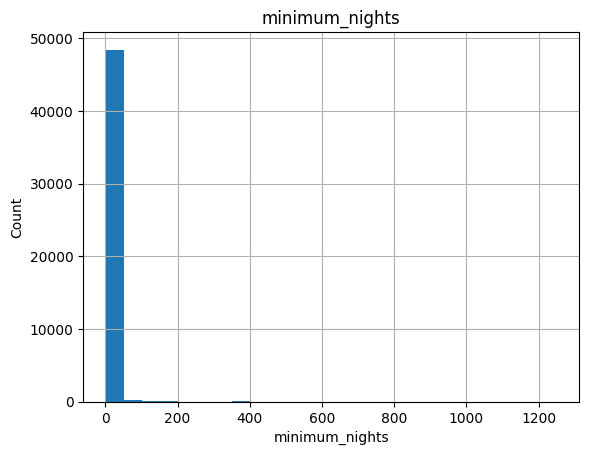

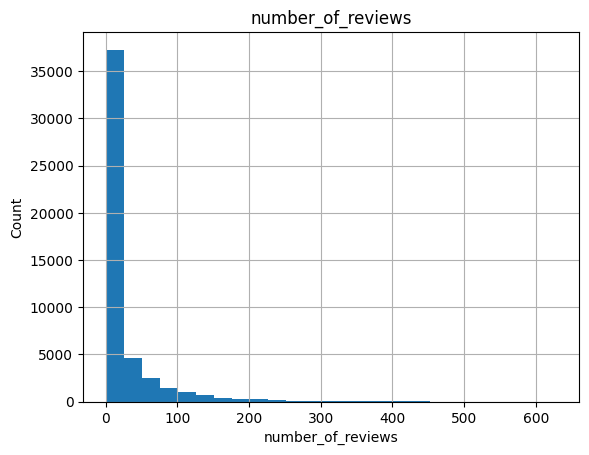

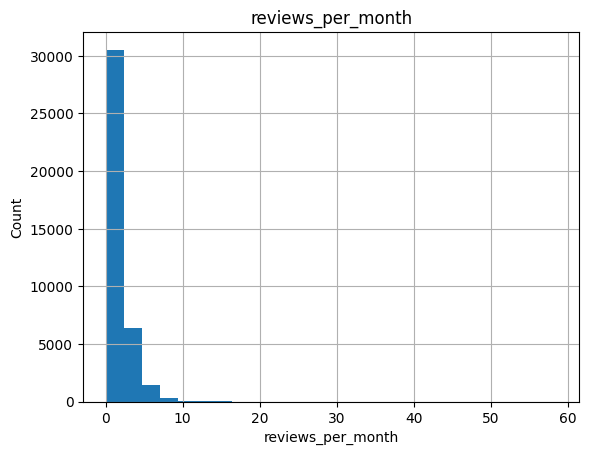

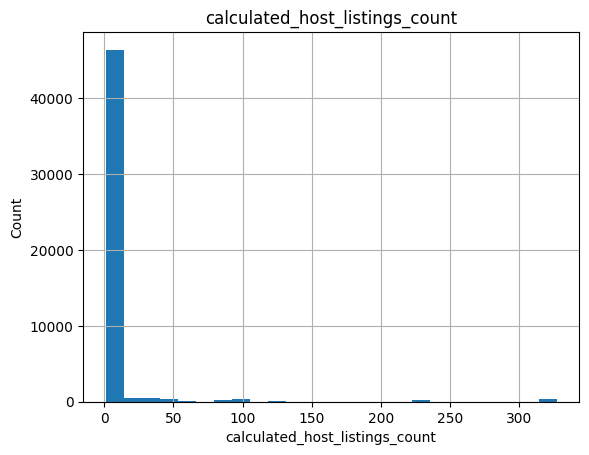

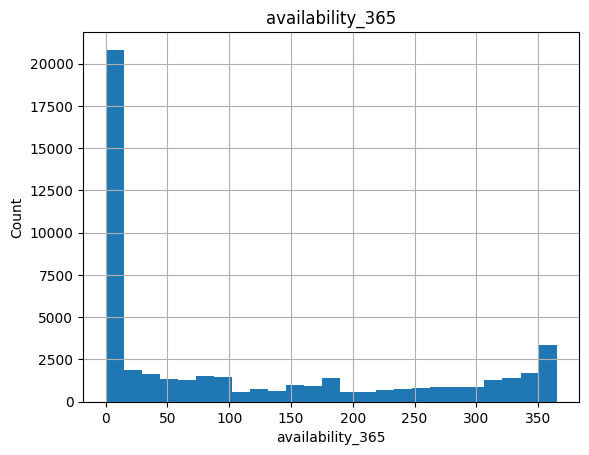

In [141]:
for feature in continuous_features:
    data = df.copy()
    data[feature].hist(bins=25)
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.title(feature)
    plt.show()

latitude and longitude both follow a sort of gaussain distribution and wont need much normalization if we choose in feature selection.

However the other continuous features are very left skewed and will some sort of normalizaition or standardization if chosen

# outliers 

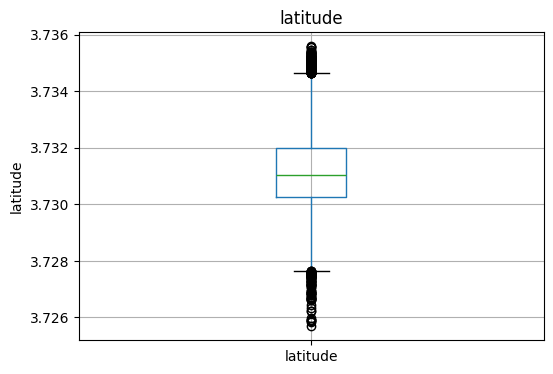

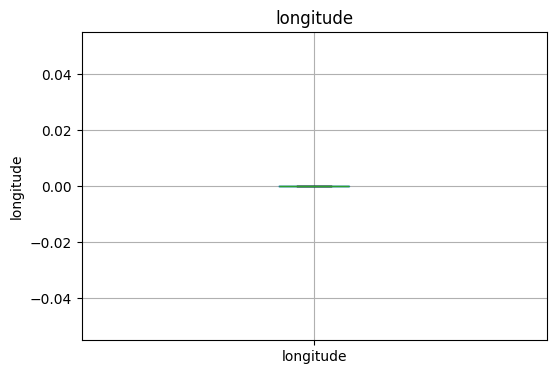

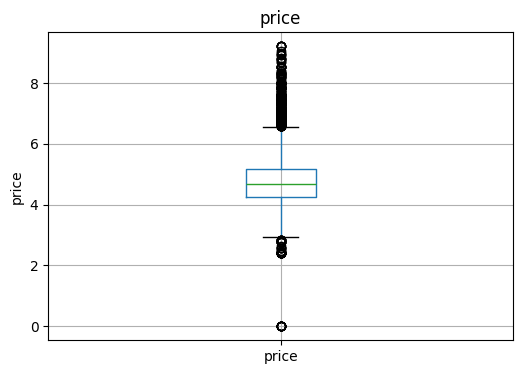

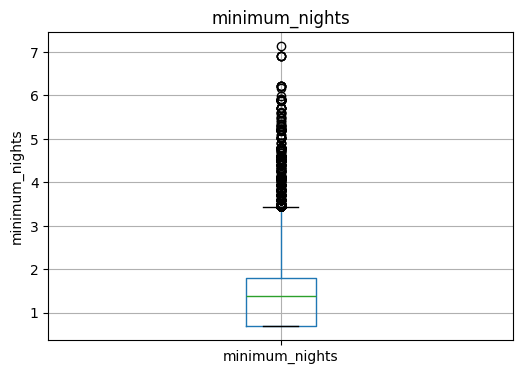

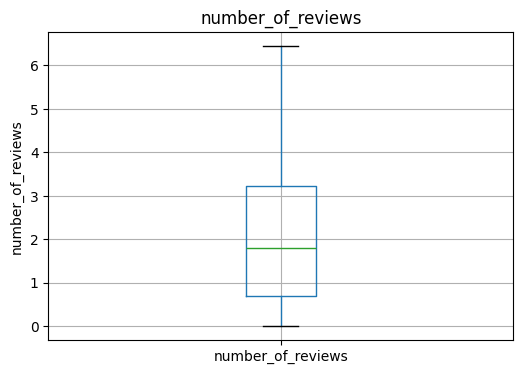

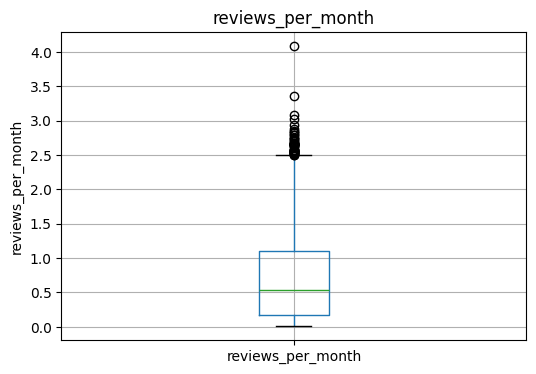

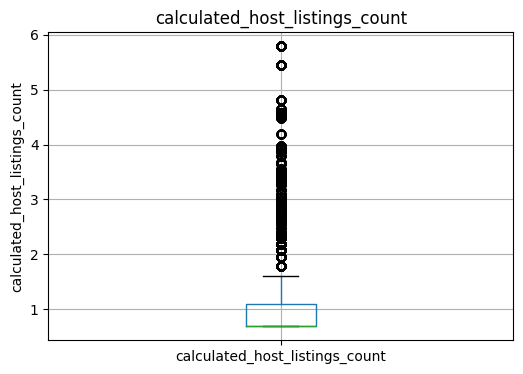

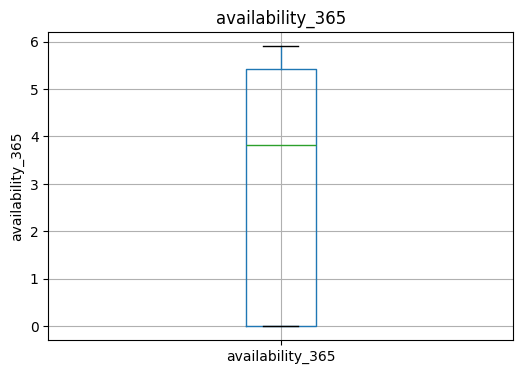

In [142]:
for feature in continuous_features:
    data = df.copy()

    data[feature] = data[feature].clip(lower=0)

    # log normalizing the data because box plots are sensitive to skewed data, as we saw in the last section 
    data[feature] = np.log1p(data[feature])

    plt.figure(figsize=(6, 4))
    data.boxplot(column=feature)
    plt.ylabel(feature)
    plt.title(feature)
    plt.show()

a lot of outliers appear in the calculated host listings count, reviews per month, minimum nights, price and latitude 

# categorical features

In [143]:
categorical_features = [feature for feature in df.columns if df[feature].dtypes == 'O']
categorical_features

['name', 'host_name', 'neighbourhood_group', 'neighbourhood', 'room_type']

In [144]:
print('Number of types per feature')
for feature in categorical_features:
    if feature not in ['name', 'host_name']:
        print(f'{feature}: {len(df[feature].unique())}')

Number of types per feature
neighbourhood_group: 5
neighbourhood: 221
room_type: 3


In [145]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaT,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


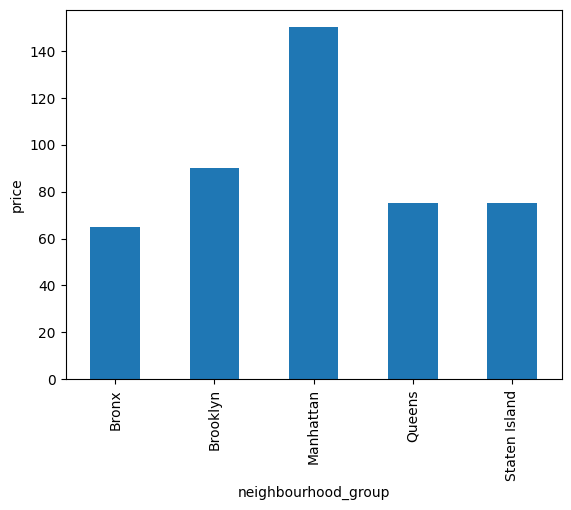

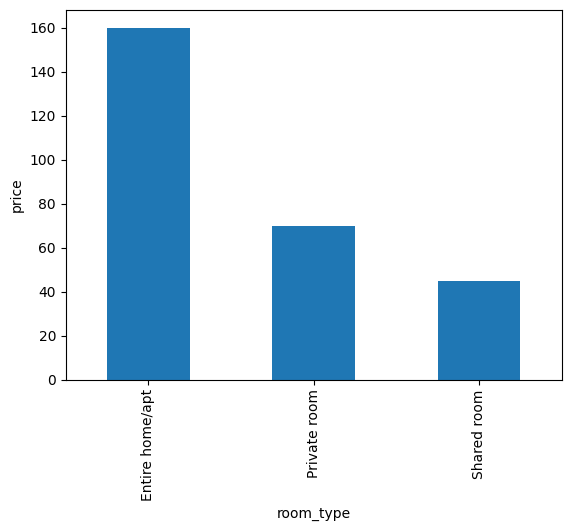

In [146]:
for feature in categorical_features:
    if feature not in ['name', 'host_name', 'neighbourhood']:
        data = df.copy()
        data.groupby(feature)['price'].median().plot.bar()
        plt.xlabel(feature)
        plt.ylabel('price')
        plt.show()

In [147]:
import folium
from folium.plugins import MarkerCluster

In [148]:
'Kew Gardens' in df['neighbourhood'].unique()

True

wanting to try something new so I am going to attempt to vizualize the neighborhood prices by a choropleth map 

In [149]:
import json

In [150]:
with open('Data/nyc-neighborhoods.geo.json') as f:
    neighborhood_geojson = json.load(f)

In [151]:
neighborhood_geojson['features'][0]['properties']


{'name': 'Todt Hill-Emerson Hill-Heartland Village-Lighthouse Hill'}

In [152]:
price_by_neighborhood = df.groupby('neighbourhood')['price'].mean().reset_index()

price_by_neighborhood.columns = ['neighborhood', 'avg_price']

In [153]:
cap = price_by_neighborhood['avg_price'].quantile(0.75)
price_by_neighborhood['avg_price_clipped'] = price_by_neighborhood['avg_price'].clip(upper=cap)

In [154]:
map_center = [df['latitude'].mean(), df['longitude'].mean()]
airbnb_map = folium.Map(location=map_center, zoom_start=11)

folium.Choropleth(
    geo_data=neighborhood_geojson,
    data= price_by_neighborhood,
    columns=['neighborhood', 'avg_price'],
    key_on='feature.properties.name',  # or the actual property name in your GeoJSON
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Average Airbnb Price ($)'
).add_to(airbnb_map)

airbnb_map

In [155]:
geojson_names = set([feature['properties']['name'].strip().lower() for feature in neighborhood_geojson['features']])
df_names = set(price_by_neighborhood['neighborhood'].str.strip().str.lower())

unmatched = geojson_names - df_names
print("Unmatched GeoJSON neighborhoods:", unmatched)

Unmatched GeoJSON neighborhoods: {'pomonok-flushing heights-hillcrest', 'madison', 'morrisania-melrose', 'lindenwood-howard beach', 'hamilton heights', 'fordham south', 'upper east side-carnegie hill', 'crotona park east', 'stapleton-rosebank', 'kensington-ocean parkway', 'spuyten duyvil-kingsbridge', 'todt hill-emerson hill-heartland village-lighthouse hill', 'auburndale', 'central harlem south', 'park slope-gowanus', 'starrett city', 'ocean parkway south', 'north side-south side', 'eastchester-edenwald-baychester', 'bedford', 'yorkville', 'west concourse', 'bensonhurst west', 'carroll gardens-columbia street-red hook', 'stuyvesant town-cooper village', 'murray hill-kips bay', 'queensbridge-ravenswood-long island city', 'van cortlandt village', 'soundview-bruckner', 'woodlawn-wakefield', 'battery park city-lower manhattan', 'melrose south-mott haven north', 'new springville-bloomfield-travis', 'elmhurst-maspeth', 'old town-dongan hills-south beach', 'baisley park', 'marble hill-inwood

I am unable to find a geojson file with matching neighborhoods, so I will just do a top-N bar chart 

top 15

<Axes: xlabel='neighbourhood'>

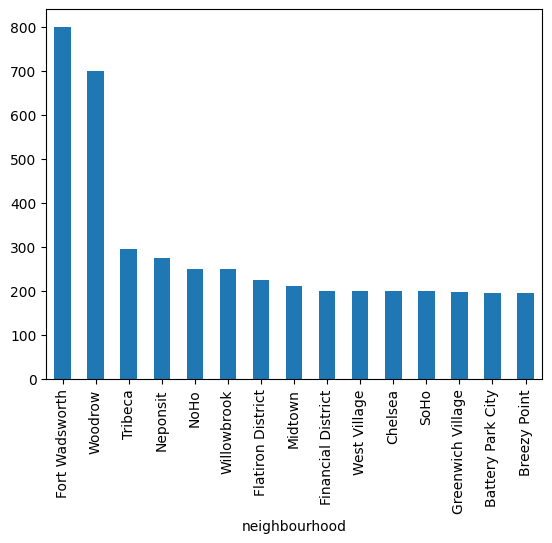

In [156]:
df.groupby('neighbourhood')['price'].median().sort_values(ascending=False).head(15).plot.bar()

In [157]:
fw_listings = df[df['neighbourhood'] == 'Fort Wadsworth']
fw_listings

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
25386,20305160,Beach House Retreat. 15 minutes from Manhattan.,1715301,Mark,Staten Island,Fort Wadsworth,40.59546,-74.06092,Entire home/apt,800,7,0,NaT,NaN,3,365


Fort Wadsworth showed a median nightly price of $800, but this was based on a single listing, making it a statistical outlier rather than a reliable indicator of the area's typical Airbnb rates.

In [158]:
wdw_listings = df[df['neighbourhood'] == 'Woodrow']
wdw_listings

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
3049,1798271,Spacious center hall colonial,9430973,Donna,Staten Island,Woodrow,40.53884,-74.19826,Entire home/apt,700,7,0,NaT,NaN,1,0


same goes for woodrow 

# Feature engineering 

In [159]:
from sklearn.model_selection import train_test_split

In [160]:
# I am going to split the data now to avoid any data leakage

# dropping columns now that will not help for prediction 

X = df.drop(columns=['price', 'id', 'name', 'host_id', 'host_name', 'last_review'])
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=23)

In [161]:
df.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

# Missing values    

In [162]:
# Missing categorical values in train set 
nan_cats = [feature for feature in X.columns if X[feature].isnull().sum() > 0 and X[feature].dtype == 'O']

nan_cats


[]

no missing categorical features in the training set 

In [163]:
nan_nums = [feature for feature in X.columns if X[feature].isnull().sum()>0 and X[feature].dtype != 'O']

for feature in nan_nums:
    print(f'{feature}: {np.round(X[feature].isnull().mean(), 4)}')

reviews_per_month: 0.2056


only have missing values in the reviews per month category 

In [164]:
# I will be using median to replace the missing values in this category 
# instead of mode since we have outliers as we saw in the box plot 

median_value = X_train[feature].median()

# creating a new feature in the dataset in order to caputure more information from the missnig values
# We saw price was somewhat dependent on if the value was missing or not in the bar charts earlier 
X_train['reviews_per_month nan'] = np.where(X_train['reviews_per_month'].isnull(),1,0)
X_test['reviews_per_month nan'] = np.where(X_test['reviews_per_month'].isnull(),1,0)

X_train['reviews_per_month'].fillna(median_value, inplace=True)
X_test['reviews_per_month'].fillna(median_value, inplace=True)

C:\Users\logan\AppData\Local\Temp\ipykernel_21392\4148454200.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train['reviews_per_month'].fillna(median_value, inplace=True)
C:\Users\logan\AppData\Local\Temp\ipykernel_21392\4148454200.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as

In [165]:
X_train['reviews_per_month'].isnull().sum()

0

In [166]:
X_test['reviews_per_month'].isnull().sum()

0

In [167]:
X_train.head(10)

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,reviews_per_month nan
35536,Queens,Bellerose,40.73258,-73.72600,Private room,1,3,0.47,2,0,0
17189,Manhattan,East Village,40.72402,-73.97778,Entire home/apt,2,0,0.72,1,0,1
32162,Queens,Rockaway Beach,40.58794,-73.81579,Entire home/apt,30,34,2.64,1,84,0
38541,Brooklyn,Greenpoint,40.73468,-73.95418,Entire home/apt,5,2,0.32,1,0,0
40652,Queens,Bayside,40.75409,-73.76935,Private room,1,19,3.63,3,350,0
25210,Brooklyn,Prospect Heights,40.67714,-73.96437,Entire home/apt,2,0,0.72,1,0,1
43379,Brooklyn,East Flatbush,40.64673,-73.94686,Entire home/apt,1,28,10.77,1,292,0
11122,Queens,Astoria,40.76258,-73.92141,Private room,3,1,0.02,2,36,0
8518,Brooklyn,Red Hook,40.67811,-74.00606,Entire home/apt,7,2,0.04,1,0,0
46192,Manhattan,Harlem,40.82693,-73.95142,Entire home/apt,60,0,0.72,1,311,1


# Normalizing numerical features 

For our skewed numerical features (like we saw in earlier histograms) I will use a log transformation 

I ran into a typo error in my skewed feature list, that is why not all of them appear in the current list, as some of them were already log transformed before the error occured 

In [168]:
skewed_features = ['minimum_nights','number_of_reviews','calculated_host_listings_count', 'availability_365']

for feature in skewed_features:
    X_train[feature] = np.log1p(X_train[feature])
    X_test[feature] = np.log1p(X_test[feature])

y_test = np.log1p(y_test)
y_train = np.log1p(y_train)

In [169]:
X_train.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,reviews_per_month nan
35536,Queens,Bellerose,40.73258,-73.72600,Private room,0.693147,1.386294,0.47,1.098612,0.000000,0
17189,Manhattan,East Village,40.72402,-73.97778,Entire home/apt,1.098612,0.000000,0.72,0.693147,0.000000,1
32162,Queens,Rockaway Beach,40.58794,-73.81579,Entire home/apt,3.433987,3.555348,2.64,0.693147,4.442651,0
38541,Brooklyn,Greenpoint,40.73468,-73.95418,Entire home/apt,1.791759,1.098612,0.32,0.693147,0.000000,0
40652,Queens,Bayside,40.75409,-73.76935,Private room,0.693147,2.995732,3.63,1.386294,5.860786,0


In [170]:
log_transformed = ['minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']

X_train[log_transformed].skew()


minimum_nights                    1.490630
number_of_reviews                 0.363387
reviews_per_month                 3.897216
calculated_host_listings_count    3.290233
availability_365                 -0.196037
dtype: float64

In [171]:
y_train.skew()

0.5696252583115226

# Categorical variables

I will be replacing all categorical labels that appear less than 1% into a new label called 'rare_var'

this will likely only take affect on the neighnorhood columnn, but it will help as we saw in the top N bar charts

In [172]:
# taking our earlier list of categorical features but removing the ones we dropped earlier 
categorical_features = [feature for feature in categorical_features if feature not in {'name', 'host_name'}]

categorical_features

['neighbourhood_group', 'neighbourhood', 'room_type']

In [173]:
for feature in categorical_features:
    freq = X_train[feature].value_counts(normalize=True)
    common_cats = freq[freq>0.01].index
    X_train[feature]= np.where(X_train[feature].isin(common_cats),X_train[feature],'rare_var')

forgot to do it on the test set as well, so I will do in this loop now 

In [174]:
for feature in categorical_features:
    freq = X_test[feature].value_counts(normalize=True)
    common_cats = freq[freq>0.01].index
    X_test[feature]= np.where(X_test[feature].isin(common_cats),X_test[feature],'rare_var')

In [175]:
for feature in categorical_features:
    print(f'{feature}: {len(X_train[feature].unique())}')

neighbourhood_group: 5
neighbourhood: 25
room_type: 3


# Scaling the numerical values and encoding categorical variables

In [176]:
num_features_to_scale = [feature for feature in X_train.columns if X_train[feature].dtype != 'O']

num_features_to_scale

['latitude',
 'longitude',
 'minimum_nights',
 'number_of_reviews',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365',
 'reviews_per_month nan']

In [177]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [178]:
X_train.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,reviews_per_month nan
35536,Queens,rare_var,40.73258,-73.72600,Private room,0.693147,1.386294,0.47,1.098612,0.000000,0
17189,Manhattan,East Village,40.72402,-73.97778,Entire home/apt,1.098612,0.000000,0.72,0.693147,0.000000,1
32162,Queens,rare_var,40.58794,-73.81579,Entire home/apt,3.433987,3.555348,2.64,0.693147,4.442651,0
38541,Brooklyn,Greenpoint,40.73468,-73.95418,Entire home/apt,1.791759,1.098612,0.32,0.693147,0.000000,0
40652,Queens,rare_var,40.75409,-73.76935,Private room,0.693147,2.995732,3.63,1.386294,5.860786,0


encoding categoricals with one hot encoding 

In [179]:
categorical_features

['neighbourhood_group', 'neighbourhood', 'room_type']

In [180]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).set_output(transform='pandas')

In [181]:
ohe_transform = ohe.fit_transform(X_train[categorical_features])

ohe_transform

,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_rare_var,neighbourhood_Astoria,neighbourhood_Bedford-Stuyvesant,neighbourhood_Bushwick,neighbourhood_Chelsea,neighbourhood_Clinton Hill,...,neighbourhood_Prospect-Lefferts Gardens,neighbourhood_Upper East Side,neighbourhood_Upper West Side,neighbourhood_Washington Heights,neighbourhood_West Village,neighbourhood_Williamsburg,neighbourhood_rare_var,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
35536,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
17189,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
32162,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
38541,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
40652,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9704,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
11190,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
26569,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9256,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [182]:
ohe_test_transformed = ohe.transform(X_test[categorical_features])

In [183]:
X_train

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,reviews_per_month nan
35536,Queens,rare_var,40.73258,-73.72600,Private room,0.693147,1.386294,0.47,1.098612,0.000000,0
17189,Manhattan,East Village,40.72402,-73.97778,Entire home/apt,1.098612,0.000000,0.72,0.693147,0.000000,1
32162,Queens,rare_var,40.58794,-73.81579,Entire home/apt,3.433987,3.555348,2.64,0.693147,4.442651,0
38541,Brooklyn,Greenpoint,40.73468,-73.95418,Entire home/apt,1.791759,1.098612,0.32,0.693147,0.000000,0
40652,Queens,rare_var,40.75409,-73.76935,Private room,0.693147,2.995732,3.63,1.386294,5.860786,0
...,...,...,...,...,...,...,...,...,...,...,...
9704,Brooklyn,Williamsburg,40.70275,-73.93445,Entire home/apt,0.693147,5.257495,3.97,0.693147,5.673323,0
11190,Brooklyn,Bushwick,40.68697,-73.91592,Private room,0.693147,0.000000,0.72,0.693147,0.000000,1
26569,Manhattan,Upper West Side,40.77576,-73.98883,Entire home/apt,3.433987,1.609438,0.22,3.258097,5.641907,0
9256,Brooklyn,Williamsburg,40.71067,-73.95419,Private room,1.098612,4.779123,2.54,0.693147,2.708050,0


Using standard scalar to standardize numerical features 

In [187]:
ss = StandardScaler().set_output(transform='pandas')

In [188]:
X_train_scaled = ss.fit_transform(X_train[num_features_to_scale])
X_test_scaled = ss.transform(X_test[num_features_to_scale])

In [189]:
X_train_scaled

,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,reviews_per_month nan
35536,0.070323,4.893122,-0.930132,-0.387965,-0.504233,0.013252,-1.215786,-0.506800
17189,-0.086129,-0.554213,-0.463184,-1.275852,-0.341576,-0.458063,-1.215786,1.973165
32162,-2.573275,2.950489,2.226316,1.001259,0.907634,-0.458063,0.590081,-0.506800
38541,0.108705,-0.043620,0.335069,-0.572218,-0.601828,-0.458063,-1.215786,-0.506800
40652,0.463463,3.955232,-0.930132,0.642840,1.551758,0.347655,1.166530,-0.506800
...,...,...,...,...,...,...,...,...
9704,-0.474883,0.383245,-0.930132,2.091442,1.772973,-0.458063,1.090330,-0.506800
11190,-0.763295,0.784147,-0.930132,-1.275852,-0.341576,-0.458063,-1.215786,1.973165
26569,0.859528,-0.793283,2.226316,-0.245047,-0.666891,2.523449,1.077560,-0.506800
9256,-0.330128,-0.043836,-0.463184,1.785057,0.842571,-0.458063,-0.115007,-0.506800


In [190]:
X_train_final = pd.concat([ohe_transform, X_train_scaled], axis=1)
X_test_final = pd.concat([ohe_test_transformed, X_test_scaled], axis=1)

In [191]:
X_train_final

,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_rare_var,neighbourhood_Astoria,neighbourhood_Bedford-Stuyvesant,neighbourhood_Bushwick,neighbourhood_Chelsea,neighbourhood_Clinton Hill,...,room_type_Private room,room_type_Shared room,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,reviews_per_month nan
35536,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.070323,4.893122,-0.930132,-0.387965,-0.504233,0.013252,-1.215786,-0.506800
17189,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.086129,-0.554213,-0.463184,-1.275852,-0.341576,-0.458063,-1.215786,1.973165
32162,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-2.573275,2.950489,2.226316,1.001259,0.907634,-0.458063,0.590081,-0.506800
38541,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.108705,-0.043620,0.335069,-0.572218,-0.601828,-0.458063,-1.215786,-0.506800
40652,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.463463,3.955232,-0.930132,0.642840,1.551758,0.347655,1.166530,-0.506800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9704,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.474883,0.383245,-0.930132,2.091442,1.772973,-0.458063,1.090330,-0.506800
11190,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,-0.763295,0.784147,-0.930132,-1.275852,-0.341576,-0.458063,-1.215786,1.973165
26569,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.859528,-0.793283,2.226316,-0.245047,-0.666891,2.523449,1.077560,-0.506800
9256,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,-0.330128,-0.043836,-0.463184,1.785057,0.842571,-0.458063,-0.115007,-0.506800


In [192]:
X_train_final.columns

Index(['neighbourhood_group_Bronx', 'neighbourhood_group_Brooklyn',
       'neighbourhood_group_Manhattan', 'neighbourhood_group_Queens',
       'neighbourhood_group_rare_var', 'neighbourhood_Astoria',
       'neighbourhood_Bedford-Stuyvesant', 'neighbourhood_Bushwick',
       'neighbourhood_Chelsea', 'neighbourhood_Clinton Hill',
       'neighbourhood_Crown Heights', 'neighbourhood_East Flatbush',
       'neighbourhood_East Harlem', 'neighbourhood_East Village',
       'neighbourhood_Financial District', 'neighbourhood_Flatbush',
       'neighbourhood_Greenpoint', 'neighbourhood_Harlem',
       'neighbourhood_Hell's Kitchen', 'neighbourhood_Long Island City',
       'neighbourhood_Lower East Side', 'neighbourhood_Midtown',
       'neighbourhood_Park Slope', 'neighbourhood_Prospect-Lefferts Gardens',
       'neighbourhood_Upper East Side', 'neighbourhood_Upper West Side',
       'neighbourhood_Washington Heights', 'neighbourhood_West Village',
       'neighbourhood_Williamsburg', 'neig

# Feature Selection - using lasso regression and sklearns selectFromModel

In [194]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel

In [ ]:
lasso_cross_val = LassoCV(cv = 5, random_state=0).fit(X_train_final, y_train)

In [196]:
print(f'best aplpha: {lasso_cross_val.alpha_}')

best aplpha: 0.00022487738989445552


In [197]:
feature_sel_model = SelectFromModel(Lasso(alpha= lasso_cross_val.alpha_, random_state=0))
feature_sel_model.fit(X_train_final, y_train)

SelectFromModel(estimator=Lasso(alpha=0.00022487738989445552, random_state=0))

In [198]:
selected_feat = X_train_final.columns[(feature_sel_model.get_support())]

print(f'total features: {X_train_final.shape[1]}')
print(f'selected features: {len(selected_feat)}')


total features: 41
selected features: 37


In [201]:
X_train_feat_dropped = X_train_final[selected_feat]
X_test_feat_dropped = X_test_final[selected_feat]

# training model - going to use Lasso regression 

In [199]:
lasso_reg = Lasso(lasso_cross_val.alpha_, random_state=0)


In [202]:
lasso_reg.fit(X_train_feat_dropped, y_train)

Lasso(alpha=0.00022487738989445552, random_state=0)

In [203]:
y_train_pred= lasso_reg.predict(X_train_feat_dropped)
y_test_pred = lasso_reg.predict(X_test_feat_dropped)

evaluationg performance using MSE and r2

In [204]:
from sklearn.metrics import mean_squared_error, r2_score

In [205]:
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f'Train MSE: {train_mse:.4f}, Train r2: {train_r2:.4f}')
print(f'Test MSE: {test_mse:.4f}, Test R2: {test_r2:.4f}')

Train MSE: 0.2257, Train r2: 0.5375
Test MSE: 0.2138, Test R2: 0.5447
